In [1]:
import DiadFit as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
import pickle
import os
from scipy.optimize import newton
plt.rcParams["pdf.fonttype"]=42
plt.rcParams["font.size"] =12


# Let's assume two FI, one trapped at HM and one at SC and temperatures spanning the whole range for ol-sat liquids at Kilauea (1100-1350 C)
- We assumed initially a temp of 1150 C (prior to SEM data), the average SEM-EDS measured Temp based on FO for the Sept 10th eruption was 1240 C

In [2]:

## This function helps find co2 density at a given depth, based on crust density model, EOS, XH2O and T

def find_co2_density_for_depth(T_K, desired_depth_km=4.0, initial_CO2_dens_gcm3=0.2,  crust_dens_kgm3=2300,XH2O=None,EOS='SW96',tolerance=0.001):

    # Define the function to minimize (the difference between desired_depth_km and the actual depth)
    def depth_difference(co2_dens_gcm3):
        result_df = pf.convert_co2_dens_press_depth(XH2O=XH2O,EOS=EOS, CO2_dens_gcm3=co2_dens_gcm3, T_K=T_K, crust_dens_kgm3=crust_dens_kgm3)
        current_depth_km = result_df.loc[0, 'Depth (km)']
        return current_depth_km - desired_depth_km

    # Use newton to find the root of depth_difference
    result = newton(depth_difference, x0=initial_CO2_dens_gcm3, tol=tolerance)

    return result

# this function to find pressure at a given depth based on crustal model alone

def find_pressure_for_depth(desired_depth_km, crust_dens_kgm3=2300, initial_P_kbar=0.903, tolerance=0.0001):

    # Define the function to minimize (the difference between desired_depth_km and the actual depth)
    def depth_difference(P_kbar):
        result_depth_km = pf.convert_pressure_to_depth(P_kbar, crust_dens_kgm3)[0]
        return result_depth_km - desired_depth_km

    # Use newton to find the root of depth_difference
    result = newton(depth_difference, x0=initial_P_kbar, tol=tolerance)

    return result



## Temp sensitivity (EOS of Span and Wagner 1996)
- assume crust density 2300 kg/m3, error only on T

In [3]:
#Find the CO2 density approximate at 1150 C and 4 and 1.5 km depths (HM and SC average depths)

median_meas_T_K=1240+273.15 # this is the average SEM-EDS measured Temp based on FO for the Sept 10th eruption
assumed_T_K=1150+273.15 # Our initial guess based on past eruption

co2_dens_4km_pure = find_co2_density_for_depth(T_K=assumed_T_K, XH2O=None, crust_dens_kgm3=2300,desired_depth_km=4.0, initial_CO2_dens_gcm3=0.2, tolerance=0.0001)
co2_dens_1km_pure = find_co2_density_for_depth(T_K=assumed_T_K, XH2O=None, crust_dens_kgm3=2300,desired_depth_km=1.5, initial_CO2_dens_gcm3=0.2, tolerance=0.0001)

co2_dens_4km_pure

0.2732543017304524

In [4]:
rhos=np.linspace(0.001,1.4,1000) # set range of densities for plotting later

T=[1100,1150,1240,1350] # set range of temps # 125K error on temp in MC (300K/2)
T_K=[t+273.15 for t in T]

# Calculate single pressures and depths for whole range of densities

P_values = [pf.convert_co2_dens_press_depth(EOS='SW96', CO2_dens_gcm3=rhos, T_K=T_K[i], crust_dens_kgm3=2300) for i in range(len(T_K))]

# Montecarlo the errors for just the example FI (stars on graphs) Here we assume the error is the entire range of Kilauean ol-sat liquids. 

MC_P_starFI=pf.propagate_FI_uncertainty(T_K=T_K[1],
error_T_K=(T_K[T_K.index(max(T_K))]-T_K[T_K.index(min(T_K))])/2, error_type_T_K='Abs', error_dist_T_K='normal',
                        CO2_dens_gcm3=pd.Series([co2_dens_1km_pure,co2_dens_4km_pure]),
                        sample_ID=pd.Series(['HM_FI','SC_FI']),
                        crust_dens_kgm3=2300,
                        N_dup=1000, fig_i=0, plot_figure=False)[0]

MC_P_starFI

working on sample number 0


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,std_dev_MC_D_km_from_percentile,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,HM_FI,0.116377,1.5,0.338445,0.337866,0.337415,0.033281,0.032109,1.497432,1.495433,0.147503,0.142307,125.0,0,0.0,1423.15,0.116377,None,2300,SW96
1,SC_FI,0.273254,4.0,0.902520,0.904580,0.907805,0.085129,0.085587,4.009131,4.023422,0.377296,0.379323,125.0,0,0.0,1423.15,0.273254,None,2300,SW96


## XH2O sensitivity

In [5]:
## import real FI data for plot
real_data=pd.read_excel("P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\RapidResponse\Submission files\Rebuttal\S2_SI_Dataset.xlsx",sheet_name="Final_Raman+SEM")
fi23=real_data[~(round(real_data['SO2_Diad_Ratio'],2)>0.22)].copy()
fi23.drop(columns=['Unnamed: 0'], inplace=True)

### Now let's calculate some theoretical FI and the ranges in our data for error propagation

# Load the polynomial using pickle
with open(r"XH2O_from_MI_Kilauea_min.pkl", 'rb') as f:
    Pf_min = pickle.load(f)
with open(r"XH2O_from_MI_Kilauea.pkl", 'rb') as f:
    Pf_av = pickle.load(f)
with open(r"XH2O_from_MI_Kilauea_max.pkl", 'rb') as f:
    Pf_max = pickle.load(f)


P_MPa_at4km=find_pressure_for_depth(desired_depth_km=4)*100
P_MPa_at1km=find_pressure_for_depth(desired_depth_km=1.5)*100

XH2O_4km=1-Pf_av(P_MPa_at4km) # This is XH2O at pressure of 90.3 MPa and crustal density model single layer 2300 kg/m3 (equivalent to depth of 4km)
XH2O_1km=1-Pf_av(P_MPa_at1km) # This is XH2O at pressure of 22.6 MPa and crustal density model single layer 2300 kg/m3 (equivalent to depth of 1km)

co2_dens_4km_XH2O = find_co2_density_for_depth(T_K=assumed_T_K, XH2O=XH2O_4km, crust_dens_kgm3=2300,desired_depth_km=4.0, initial_CO2_dens_gcm3=0.2, tolerance=0.0001)
co2_dens_1km_XH2O = find_co2_density_for_depth(T_K=assumed_T_K, XH2O=XH2O_1km, crust_dens_kgm3=2300,desired_depth_km=1.5, initial_CO2_dens_gcm3=0.2, tolerance=0.0001)

print('Approximate XH2O at a depth of 4km based on preferred polynomial: ' + str(np.round((XH2O_4km),3)))
print('Approximate XH2O at a depth of 1.5km based on preferred polynomial: ' + str(np.round((XH2O_1km),3)))

print('\nApproximate CO2 density (g/cm3) at a depth of 4km with XH2O: ' + str(np.round((co2_dens_4km_XH2O),3)))
print('Approximate CO2 density (g/cm3) at a depth of 1.5km with XH2O: ' + str(np.round((co2_dens_1km_XH2O),3)))

print('\nMedian difference in true dataset between preferred XH2O and degassed XH2O: ' + str(np.round(np.median(fi23['XH2O_i5_av']-fi23['XH2O_i5_min']),3)))
print('Median difference in true dataset between preferred XH2O and upper Kilauea limit XH2O: ' + str(np.round(np.median(fi23['XH2O_i5_max']-fi23['XH2O_i5_av']),3)))
print('Half of the whole range of XH2O in our FI dataset calculated from the maximum XH2O-P polynomial: ' + str(np.round((max(fi23['XH2O_i5_max'])-min(fi23['XH2O_i5_max']))/2,3)))

XH2O_error=np.round((max(fi23['XH2O_i5_max'])-min(fi23['XH2O_i5_max']))/2,1)

print('We round up to +-'+str(XH2O_error)+' as the maximum XH2O uncertainty for our FI dataset')



Approximate XH2O at a depth of 4km based on preferred polynomial: 0.043
Approximate XH2O at a depth of 1.5km based on preferred polynomial: 0.097

Approximate CO2 density (g/cm3) at a depth of 4km with XH2O: 0.263
Approximate CO2 density (g/cm3) at a depth of 1.5km with XH2O: 0.106

Median difference in true dataset between preferred XH2O and degassed XH2O: 0.044
Median difference in true dataset between preferred XH2O and upper Kilauea limit XH2O: 0.043
Half of the whole range of XH2O in our FI dataset calculated from the maximum XH2O-P polynomial: 0.096
We round up to +-0.1 as the maximum XH2O uncertainty for our FI dataset


In [6]:
# Calculate single pressures and depths for whole range of densities
XH2O=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8]

P_values_XH2O = [pf.convert_co2_dens_press_depth(XH2O=XH2O[i], CO2_dens_gcm3=rhos, T_K=T_K[1], crust_dens_kgm3=2300) for i in range(len(XH2O))]

# Montecarlo the errors for just the example FI (stars on graphs)

star_FI=pd.DataFrame({'Sample_ID':['HM_FI','SC_FI'],
                      'CO2_dens_gcm3':[co2_dens_1km_XH2O,co2_dens_4km_XH2O],
                      'XH2O':[XH2O_1km,XH2O_4km]
                    })

MC_P_starFI_XH2O=pf.propagate_FI_uncertainty(T_K=T_K[1],
                        CO2_dens_gcm3=star_FI['CO2_dens_gcm3'],
                        sample_ID=star_FI['Sample_ID'],
                        crust_dens_kgm3=2300,
                        XH2O=star_FI['XH2O'],error_XH2O=XH2O_error,error_type_XH2O='Abs',error_dist_XH2O='normal',
                        N_dup=1000, fig_i=0, plot_figure=False)[0]

MC_P_starFI_XH2O

You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 2006. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
working on sample number 0


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,...,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS,error_XH2O,error_type_XH2O,error_dist_XH2O
0,HM_FI,0.106263,1.5,0.338445,0.344923,0.338527,0.035256,0.03592,1.528712,1.500365,...,0,0.0,1423.15,0.106263,None,2300,SW96,0.1,Abs,normal
1,SC_FI,0.263421,4.0,0.902520,0.931605,0.900165,0.090399,0.07487,4.128908,3.989563,...,0,0.0,1423.15,0.263421,None,2300,SW96,0.1,Abs,normal


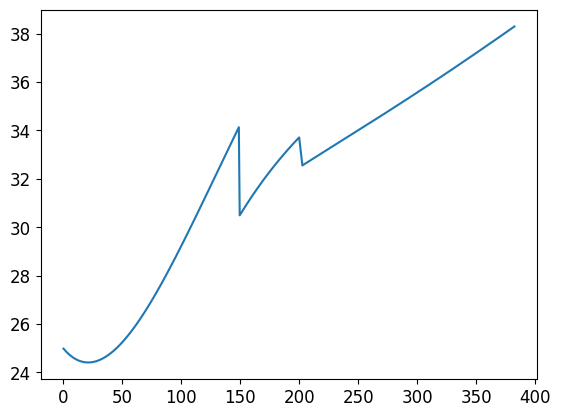

In [53]:
Pcorr=P_values_XH2O[0].copy()

Pcorr['P_correction%_atXH2O_0.1']=100*(P_values_XH2O[4]['Pressure (MPa)']-P_values_XH2O[0]['Pressure (MPa)'])/P_values_XH2O[0]['Pressure (MPa)']
Pcorr['P_correction_atXH2O_0.1']=P_values_XH2O[4]['Pressure (MPa)']-P_values_XH2O[0]['Pressure (MPa)']
Pcorr['D_correction_atXH2O_0.1']=P_values_XH2O[4]['Depth (km)']-P_values_XH2O[0]['Depth (km)']

plt.plot(Pcorr[0:500]['Pressure (MPa)'],Pcorr[0:500]['P_correction%_atXH2O_0.1'])
# plt.plot(Pcorr[500:900]['Pressure (MPa)'],Pcorr[500:900]['P_correction%_atXH2O_0.1'])

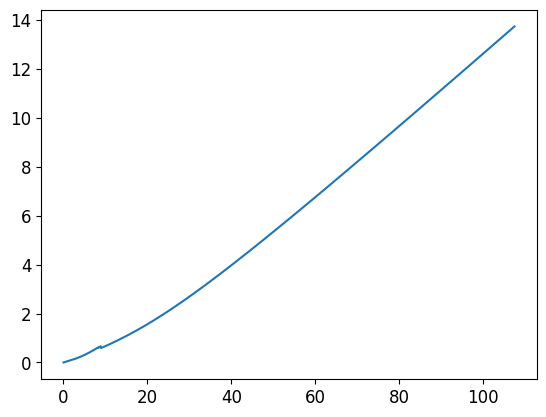

In [27]:
plt.plot(Pcorr['Depth (km)'],Pcorr['D_correction_atXH2O_0.1'])

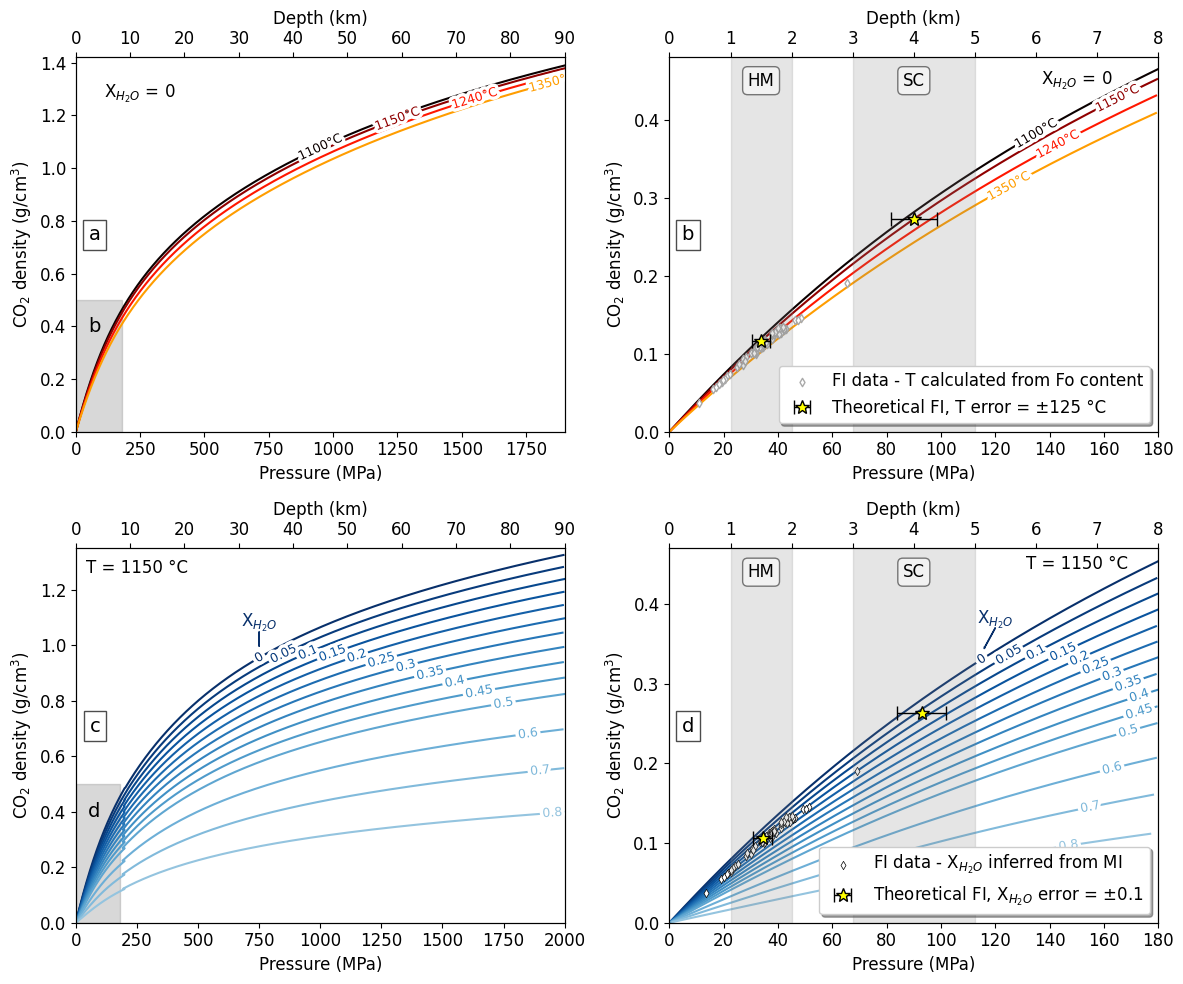

In [9]:
from matplotlib.ticker import MultipleLocator

## this stuff is to get rid of numerical instabilities in the XH2O EOS calculations, for details refer to Yamamoto et al. 2023 on Duan and Zhang 2006
P_values_XH2O_filt=[df[~((df['MC_CO2_dens_gcm3'] > 0.5) & (df['Pressure (MPa)'] < 200))].reset_index(drop=True) for df in P_values_XH2O]


# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

fig, ((ax1,ax3),(ax5,ax7)) = plt.subplots(2,2,figsize=(12,10))

#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000 
min_P_ax2 = 0
max_P_ax2 = 180

# Plotting CO2 density against Pressure on the left y-axis
for i in range(len(T_K)):
    ax1.plot(P_values[i]['Pressure (MPa)'][P_values[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values[i]['MC_CO2_dens_gcm3'][P_values[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], label=f'{T[i]}°C', color=colors[i])

# Secondary x-axis for depth in kilometers
ax2 = ax1.twiny()
for i in range(len(T_K)):
    ax2.plot(P_values[i]['Depth (km)'][P_values[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values[i]['MC_CO2_dens_gcm3'][P_values[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], color='none')

ax1.set_xlabel('Pressure (MPa)')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('CO$_2$ density (g/cm$^3$)')


ax1.set_ylim(np.round([min(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])+0.02],2))

ax1.set_xlim(np.round([min(P_values[0]['Pressure (MPa)'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values[0]['Pressure (MPa)'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax2.set_xlim(np.round([min(P_values[0]['Depth (km)'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values[0]['Depth (km)'][P_values[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))


m=250
labelLines(ax1.get_lines(), zorder=3, xvals=[700+m,1000+m,1300+m,1600+m], fontsize=9)

# add panel indicator letter
bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='k', alpha=0.7)
ax1.text(0.05, 0.50, 'a', transform=ax1.transAxes, fontsize=14, va='bottom', ha='right',bbox=bbox_props)

# plot the insert box corresponding to panel c on panel a


maxrho=round(max(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxrho]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.1]

ax1.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)
ax1.text(*text_box_coords, 'b', fontsize=14, va='center', ha='left')

ax1.text(250, 1.28, 'X$_{H_2O}$ = 0', ha='center', va='center',zorder=2,color = 'k')

############## Now plot panel b #############

for i in range(len(T_K)):
    ax3.plot(P_values[i]['Pressure (MPa)'][P_values[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values[i]['MC_CO2_dens_gcm3'][P_values[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], label=f'{T[i]}°C', color=colors[i])

# secondary x-axis for depth in kilometers
ax4 = ax3.twiny()
for i in range(len(T_K)):
    ax4.plot(P_values[i]['Depth (km)'][P_values[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values[i]['MC_CO2_dens_gcm3'][P_values[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], color='none')

ax3.set_xlabel('Pressure (MPa)')
ax4.set_xlabel('Depth (km)')
ax3.set_ylabel('CO$_2$ density (g/cm$^3$)')

ax4.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(20))

ylims_ax2=np.round([min(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values[0]['MC_CO2_dens_gcm3'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])+0.02],2)

ax3.set_ylim(ylims_ax2)
ax3.set_xlim(np.round([min(P_values[0]['Pressure (MPa)'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values[0]['Pressure (MPa)'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax4.set_xlim(np.round([min(P_values[0]['Depth (km)'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values[0]['Depth (km)'][P_values[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax4.fill_between([1, 2], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)
ax4.fill_between([3, 5], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)

labelLines(ax3.get_lines(), zorder=3, xvals=[max_P_ax2-45, max_P_ax2-15, max_P_ax2-37,max_P_ax2-55], fontsize=9)

# Add reservoir indicator boxes within the filled areas
ax4.text(1.5, maxrho-0.05, 'HM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax4.text(4, maxrho-0.05, 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)


sc1=ax3.scatter(fi23['SingleFI_P_kbar']*100,fi23['CO2_dens_gcm3'],zorder=3,marker='d',color='white', edgecolor='darkgrey',s=18,label='FI - T calculated from host Fo content')
sc2=ax4.errorbar(MC_P_starFI['Mean_MC_D_km'],MC_P_starFI['CO2_dens_gcm3'],xerr=MC_P_starFI['std_dev_MC_D_km'],fmt='*',zorder=3,markersize=10,ecolor='k',capsize=5,mfc='yellow',mec='k',elinewidth=1,label='Theoretical FI, T error = ±125 °C')

ax3.text(0.05, 0.50, 'b', transform=ax3.transAxes, fontsize=14, va='bottom', ha='right',bbox=bbox_props)
ax3.text(150, maxrho-0.05, 'X$_{H_2O}$ = 0', ha='center', va='center',zorder=2,color = 'k')


#### Plot panel c ##########

colors_XH2O = plt.cm.Blues_r(np.linspace(0, 0.6, len(XH2O)))
filter=(P_values_XH2O[0]['MC_CO2_dens_gcm3'] > 0.4) & (P_values_XH2O[0]['Pressure (MPa)'] < 200)

# Plotting CO2 density against Pressure on the left y-axis
for i in range(len(XH2O)):
    ax5.plot(P_values_XH2O_filt[i]['Pressure (MPa)'][P_values_XH2O_filt[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_XH2O_filt[i]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], label=f'{XH2O[i]}', color=colors_XH2O[i])

# Secondary x-axis for depth in kilometers
ax6 = ax5.twiny()
for i in range(len(XH2O)):
    ax6.plot(P_values_XH2O_filt[i]['Depth (km)'][P_values_XH2O_filt[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_XH2O_filt[i]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], color='none')

ax5.set_xlabel('Pressure (MPa)')
ax6.set_xlabel('Depth (km)')
ax5.set_ylabel('CO$_2$ density (g/cm$^3$)')


ax5.set_ylim(np.round([min(P_values_XH2O_filt[0]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_XH2O_filt[0]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])+0.02],2))

ax5.set_xlim(np.round([min(P_values_XH2O_filt[0]['Pressure (MPa)'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_XH2O_filt[0]['Pressure (MPa)'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax6.set_xlim(np.round([min(P_values_XH2O_filt[0]['Depth (km)'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_XH2O_filt[0]['Depth (km)'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))


m=700
labelLines(ax5.get_lines(), zorder=3, xvals=[m+50,m+150,m+250,m+350,m+450,m+550,m+650,m+750,m+850,m+950,m+1050,m+1150,m+1200,m+1250], fontsize=9)

# add panel indicator letter
bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='k', alpha=0.7)
ax5.text(0.05, 0.50, 'c', transform=ax5.transAxes, fontsize=14, va='bottom', ha='right',bbox=bbox_props)

# plot the insert box corresponding to panel c on panel a


maxrho=round(max(P_values_XH2O_filt[0]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxrho]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.1]

ax5.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)
ax5.text(*text_box_coords, 'd', fontsize=14, va='center', ha='left')

ax5.text(750, 1.08, 'X$_{H_2O}$', ha='center', va='center',zorder=2,color = colors_XH2O[0],fontsize=12)
ax5.arrow(750, 1.05, 0, -0.05, color=colors_XH2O[0])

ax5.text(250, 1.28, 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')

############## Now plot panel d #############

for i in range(len(XH2O)):
    ax7.plot(P_values_XH2O_filt[i]['Pressure (MPa)'][P_values_XH2O_filt[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_XH2O_filt[i]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], label=f'{XH2O[i]}', color=colors_XH2O[i])

# secondary x-axis for depth in kilometers
ax8 = ax7.twiny()
for i in range(len(XH2O)):
    ax8.plot(P_values_XH2O_filt[i]['Depth (km)'][P_values_XH2O_filt[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_XH2O_filt[i]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], color='none')

ax7.set_xlabel('Pressure (MPa)')
ax8.set_xlabel('Depth (km)')
ax7.set_ylabel('CO$_2$ density (g/cm$^3$)')

ax8.xaxis.set_major_locator(MultipleLocator(1))
ax7.xaxis.set_major_locator(MultipleLocator(20))

ylims_ax6=np.round([min(P_values_XH2O_filt[0]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_XH2O_filt[0]['MC_CO2_dens_gcm3'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])+0.02],2)

ax7.set_ylim(ylims_ax6)
ax7.set_xlim(np.round([min(P_values_XH2O_filt[0]['Pressure (MPa)'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_XH2O_filt[0]['Pressure (MPa)'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax8.set_xlim(np.round([min(P_values_XH2O_filt[0]['Depth (km)'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_XH2O_filt[0]['Depth (km)'][P_values_XH2O_filt[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax8.fill_between([1, 2], ylims_ax6[0],ylims_ax6[1], color='gray', alpha=0.2, zorder=-1)
ax8.fill_between([3, 5], ylims_ax6[0],ylims_ax6[1], color='gray', alpha=0.2, zorder=-1)

m=65
labelLines(ax7.get_lines(), zorder=3, xvals=[max_P_ax2-m, max_P_ax2-m+10, max_P_ax2-m+20,max_P_ax2-m+30,max_P_ax2-m+36,max_P_ax2-m+42,max_P_ax2-m+48,max_P_ax2-m+54,max_P_ax2-m+58,max_P_ax2-m+58,max_P_ax2-m+54,max_P_ax2-m+48,max_P_ax2-m+40,max_P_ax2-m+32], fontsize=9)

# Add reservoir indicator boxes within the filled areas
ax8.text(1.5, maxrho-0.06, 'HM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax8.text(4, maxrho-0.06, 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

sc3=ax7.scatter(fi23['P_kbar_mixCO2_DZ06_Hloss_i5_av']*100,fi23['CO2_dens_gcm3'],zorder=3,marker='d',color='white', edgecolor='k',s=18,linewidths=0.5,label='FI - XH2O inferred from MI')
sc4=ax8.errorbar(MC_P_starFI_XH2O['Mean_MC_D_km'],MC_P_starFI_XH2O['CO2_dens_gcm3'],xerr=MC_P_starFI_XH2O['std_dev_MC_D_km'],fmt='*',zorder=3,markersize=10,ecolor='k',capsize=5,mfc='yellow',mec='k',elinewidth=1,label='Theoretical FI, error XH2O = ±0.1')


ax7.text(0.05, 0.50, 'd', transform=ax7.transAxes, fontsize=14, va='bottom', ha='right',bbox=bbox_props)

ax7.text(150, maxrho-0.05, 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')

ax7.text(120, maxrho-0.12, 'X$_{H_2O}$', ha='center', va='center',zorder=2,color = colors_XH2O[0],fontsize=12)
ax7.arrow(120, maxrho-0.13, -4, -0.025, color=colors_XH2O[0])


ax4.legend([sc1, sc2],  ['FI data - T calculated from Fo content','Theoretical FI, T error = ±125 °C'], loc='lower right',fancybox=True, shadow=True)
ax8.legend([sc3, sc4],  ['FI data - X$_{H_2O}$ inferred from MI','Theoretical FI, X$_{H_2O}$ error = ±0.1'], loc='lower right',fancybox=True, shadow=True)

fig.tight_layout()

plt.show()
plt.rcParams["pdf.fonttype"]=42
fig.savefig(os.getcwd()+'/'+'Figures\Fig1_new_Tsensitivity.pdf')
fig.savefig(os.getcwd()+'/'+'Figures\Fig1_new_Tsensitivity.png',dpi=300)
